# Boosting and the AdaBoost Method

Using **ensemble methods** can greatly improve the results achieved with weak machine learning algorithms, also called **weak learners**. Ensemble methods achieve better performance by aggregating the results of many statistically independent models. This process averages out the errors and produces a better, final, prediction. 

In this lab you will work with widely used ensemble method known as **boosting**. Boosting is a meta-algorithm since the method can be applied to many types of machine learning algorithms. In summary, boosting iteratively improves the learning of the N models by giving greater weight to training cases with larger errors. The basic boosting procedure is simple and follows these steps:
1. N learners (machine learning models) are defined.
2. Each of i training data cases is given an initial equal weight of 1/i.
3. The N learners are trained on the weighted training data cases.
4. The prediction is computed based on a aggregation of the learners; averaging over the hypothesis of the N learners. 
5. Weights for the training data cases are updated based on the aggregated errors made by the learners. Cases with larger errors are given larger weights. 
6. Steps 3, 4, and 5 are repeated until a convergence criteria is met.

**Classification and regression tree models** are the weak learners most commonly used with boosting. In this lab you will work with one of the most widely used and successful boosted methods, known as **AdaBoost** or **adaptive boosting**. AdaBoost uses some large number, N, tree models. The rate at which weights are updated is **adaptive** with the errors. 

It is important to keep in mind that boosted machine learning is not robust to significant noise or outliers in the training data. The re-weighting process gives greater weight to the large errors, and therefore can give undue weight to outliers and errors. In cases where data is noisy, the random forest algorithm may prove to be more robust. 

## Example: Iris dataset

As a first example you will use AdaBoost to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

> **Note:** If you are running in Azure Notebooks, make sure that you run the code in the `setup.ipynb` notebook at the start of you session to ensure your environment is correctly configured. 

In [12]:
## Import packages
library(ggplot2)
library(gridExtra)
library(repr)
library(dplyr)
library(caret)
library(gbm)
library(e1071)
library(MLmetrics)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

In [13]:
install.packages('gbm')

Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5:
  cannot open URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5/PACKAGES'"Warning message:
"package 'gbm' is in use and will not be installed"

In [10]:
install.packages('e1071')

Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5:
  cannot open URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5/PACKAGES'"

package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Philip\AppData\Local\Temp\Rtmpo36SrU\downloaded_packages


The code in the cell below displays the head of the data frame and plots all pairwise combinations of the features with the species of the iris flower in colors. Execute this code and examine the results.  

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


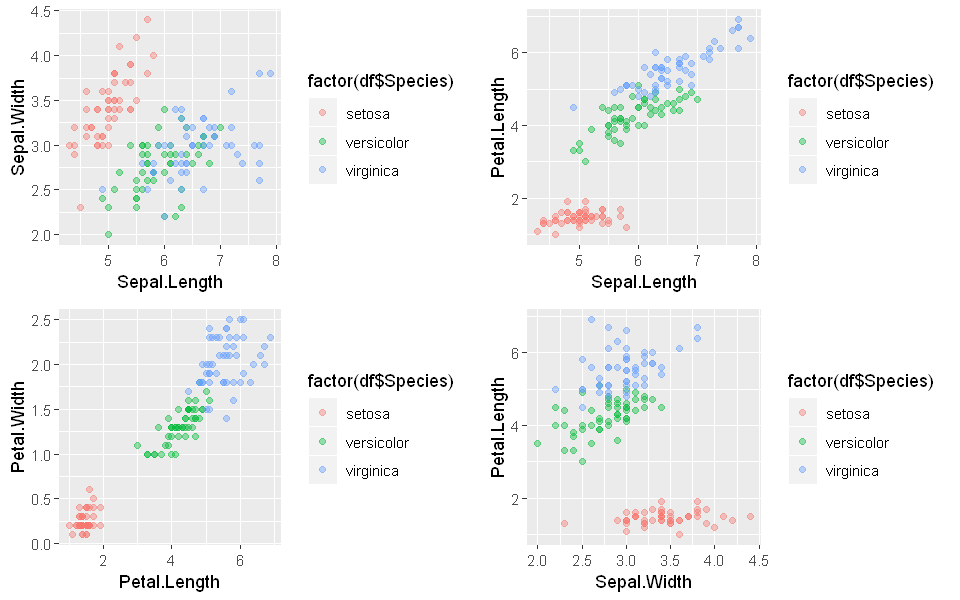

In [14]:
single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species)), alpha = 0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

head(iris, 10)   
plot_iris(iris) 

You can see that Setosa (in red) is well separated from the other two categories. The Versicolor (in green) and the Virginica (in blue) show considerable overlap. The question is how well our classifier will separate these categories. 

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 67% of the cases are being used as the test dataset. 

In [15]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times = 1, p = 0.33, list = FALSE)
training = iris[partition,] # Create the training sample
dim(training)
test = iris[-partition,] # Create the test sample
dim(test)

[1] 51  5

[1] 99  5

As is always the case with machine learning, numeric features  must be scaled. Execute the code in the cell below to scale the training and test datasets:

In [16]:
num_cols = c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.2646501,0.4563512,-1.348274,-1.287390
5,-0.9016267,1.4161001,-1.293220,-1.287390
6,-0.4175955,2.1359118,-1.128059,-1.027876
9,-1.6276734,-0.2634605,-1.293220,-1.287390
10,-1.0226345,0.2164140,-1.238167,-1.417146
11,-0.4175955,1.6560373,-1.238167,-1.287390


Now you will define and fit an AdaBoosted tree model. The code in the cell below defines the model with 5 estimators (trees) using the `gbm` function from the R gbm  package, and then fits the model. Since this is a multi-class classification problem a multinomial distribution is specified for the model response. Execute this code.

In [17]:
set.seed(3355)
gbm_mod = gbm(Species ~ ., data = training, distribution = "multinomial", n.trees = 5)

Next, the code in the cell below uses the `predict` method is used to compute the multinomial class probabilities from the scaled features. Execute this code. 

In [18]:
test$probs = predict(gbm_mod, newdata = test, n.trees = 5)
test[1:10,]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,probs
1,-0.78061890,1.17616289,-1.293220,-1.287390,setosa,0.011800578
2,-1.02263448,-0.02352326,-1.293220,-1.287390,setosa,0.011800578
4,-1.38565786,0.21641397,-1.238167,-1.287390,setosa,0.011800578
7,-1.38565786,0.93622566,-1.293220,-1.157633,setosa,0.011800578
8,-0.90162669,0.93622566,-1.238167,-1.287390,setosa,0.011800578
12,-1.14364227,0.93622566,-1.183113,-1.287390,setosa,0.011800578
14,-1.74868124,-0.02352326,-1.458381,-1.417146,setosa,0.011800578
15,0.06643565,2.37584904,-1.403328,-1.287390,setosa,-0.003465665
16,-0.05457214,3.33559795,-1.238167,-1.027876,setosa,-0.003465665
19,-0.05457214,1.89597458,-1.128059,-1.157633,setosa,-0.003465665


You can see the species and multinomial probabilities for the classes, along with the species of the the flower. 

The code in the cell below uses the R `which.max` function to compute classes from the maximum of the probabilities. Execute this code.

In [19]:
test$scores = apply(test$probs, 1, which.max) # Find the class with the maximum probability
test$scores = ifelse(test$scores == 1, 'sentosa', ifelse(test$scores == 2, 'versicolor', 'virginica'))
test[1:10,]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,probs,scores
1,-0.78061890,1.17616289,-1.293220,-1.287390,setosa,0.011800578,sentosa
2,-1.02263448,-0.02352326,-1.293220,-1.287390,setosa,0.011800578,sentosa
4,-1.38565786,0.21641397,-1.238167,-1.287390,setosa,0.011800578,sentosa
7,-1.38565786,0.93622566,-1.293220,-1.157633,setosa,0.011800578,sentosa
8,-0.90162669,0.93622566,-1.238167,-1.287390,setosa,0.011800578,sentosa
12,-1.14364227,0.93622566,-1.183113,-1.287390,setosa,0.011800578,sentosa
14,-1.74868124,-0.02352326,-1.458381,-1.417146,setosa,0.011800578,sentosa
15,0.06643565,2.37584904,-1.403328,-1.287390,setosa,-0.003465665,versicolor
16,-0.05457214,3.33559795,-1.238167,-1.027876,setosa,-0.003465665,versicolor
19,-0.05457214,1.89597458,-1.128059,-1.157633,setosa,-0.003465665,versicolor


It is time to evaluate the model results. Keep in mind that the problem has been made deliberately difficult, by having more test cases than training cases. The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from previous labs to deal with a three category problem. Execute this code and examine the results.

In [20]:
print_metrics = function(df, label){
    ## Compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)

    ## Compute and print accuracy 
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm), 3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)), '\n \n')                           

    ## Compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))    
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))    
    metrics = sapply(c(precision, recall, F1), round, 3)        
    metrics = t(matrix(metrics, nrow = nrow(cm), ncol = ncol(cm)))       
    dimnames(metrics) = list(c('Precision', 'Recall', 'F1'), unique(test$Species))      
    print(metrics)
}  
print_metrics(test, 'Species')   

            Predicted
Actual       sentosa versicolor virginica
  setosa          30          3         0
  versicolor       4         20         9
  virginica        1          0        32

Accuracy =  0.828 
 
          setosa versicolor virginica
Precision  0.909      0.606     0.970
Recall     0.857      0.870     0.780
F1         0.882      0.714     0.865


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified, but with a few errors. 
2. The overall accuracy is 0.83. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 50 cases. 
3. The precision, recall and  F1 for each of the classes are reasonable.

The above results were computed using an ensemble with only 5 trees. Will more trees in the ensemble help? To find out, execute this code and examine the results. 

Then, answer **Question 1** on the course page.

In [21]:
set.seed(8899)
gbm_mod = gbm(Species ~ ., data = training, distribution = "multinomial", n.trees = 100)
test$probs = predict(gbm_mod, newdata = test, n.trees = 100)
test$scores = apply(test$probs, 1, which.max) # Find the class with the maximum probability
test$scores = ifelse(test$scores == 1, 'sentosa', ifelse(test$scores == 2, 'versicolor', 'virginica'))
print_metrics(test, 'Species')  

            Predicted
Actual       sentosa versicolor virginica
  setosa          33          0         0
  versicolor       2         21        10
  virginica        0          1        32

Accuracy =  0.869 
 
          setosa versicolor virginica
Precision  1.000      0.636     0.970
Recall     0.943      0.955     0.762
F1         0.971      0.764     0.853


These metrics show a small improvement. Using more trees in the ensemble has resulted in a better model. 

How important are each of the features for this model? The R Caret package provides the capability to find out. As a first step, `gbm` models must be trained using the the Caret `train` function. The code in the cell below does this, using the default model arguments. The default arguments for the model are specified with the `tuneGrid` argument of `train`. Execute the code.

In [22]:
gbm_mod_train = train(Species ~ ., data = training, method = "gbm", verbose = FALSE,
            distribution = "multinomial", trControl=trainControl(number=100),
            tuneGrid=expand.grid(n.trees = 100,
                                 interaction.depth = 1, 
                                 n.minobsinnode = 10, 
                                 shrinkage = 0.001))

With the Caret model object trained, the feature importance can be computed and displayed. Execute this code and examine the results. 

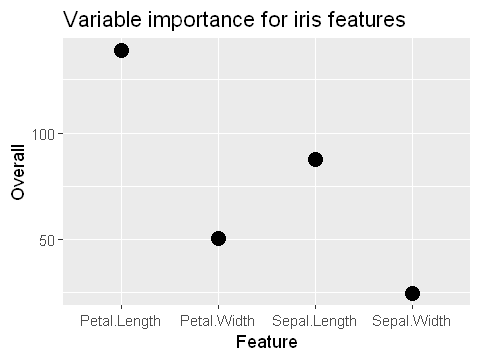

In [23]:
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(gbm_mod_train, scale = FALSE)$importance
imp[,'Feature'] = row.names(imp)
ggplot(imp, aes(x = Feature, y = Overall)) + geom_point(size = 4) +
       ggtitle('Variable importance for iris features')

Observe the following:
1. Petal length is the most importance feature.
2. Sepal width is the least important feature. 

The question now is, if a model with a reduced feature set will be an improvement. Execute the code in the cell below which creates a model using three of the four features.

Then, answer **Question 2** on the course page.

In [24]:
set.seed(8899)
gbm_mod = gbm(Species ~ Petal.Length + Petal.Width + Sepal.Length, 
              data = training, distribution = "multinomial", n.trees = 100)
test$probs = predict(gbm_mod, newdata = test, n.trees = 100)
test$scores = apply(test$probs, 1, which.max) # Find the class with the maximum probability
test$scores = ifelse(test$scores == 1, 'sentosa', ifelse(test$scores == 2, 'versicolor', 'virginica'))
print_metrics(test, 'Species')  

            Predicted
Actual       sentosa versicolor virginica
  setosa          33          0         0
  versicolor       2         24         7
  virginica        0          1        32

Accuracy =  0.899 
 
          setosa versicolor virginica
Precision  1.000      0.727     0.970
Recall     0.943      0.960     0.821
F1         0.971      0.828     0.889


The model with reduced feature set has slightly improved metrics. Overall, this model is preferred since it is more likely to generalize. 

The code in the cell below plots the classes of the iris flower along with the classification errors shown by shape. Execute this code and examine the results.  

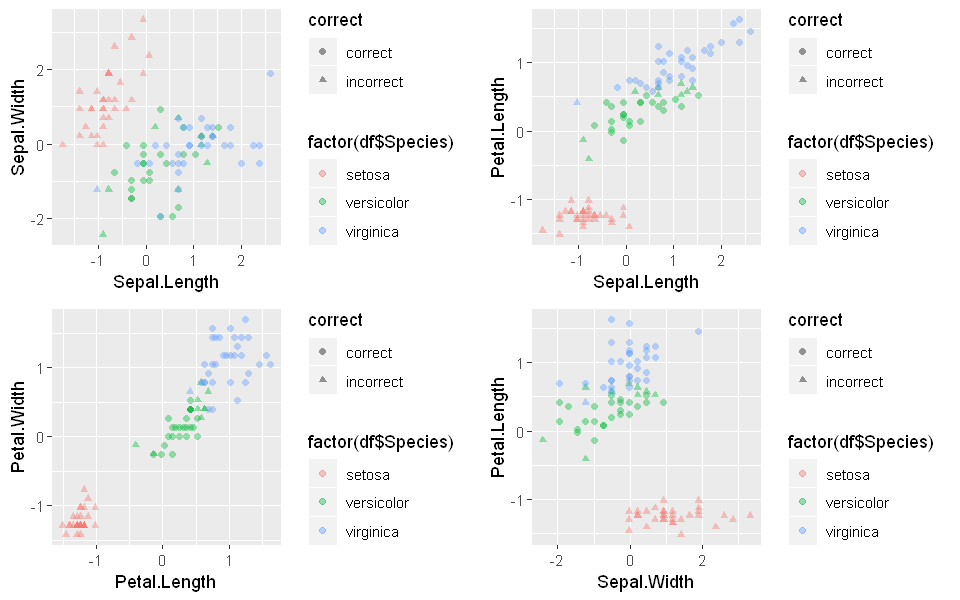

In [25]:
## Create column of correct-incorrect classification
test$correct = ifelse(test$Species == test$scores, 'correct', 'incorrect')

single_plot_classes = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species), shape = correct), alpha = 0.4)
}

plot_iris_classes = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot_classes(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot_classes(df, 'Sepal.Length', 'Petal.Length'),
        single_plot_classes(df, 'Petal.Length', 'Petal.Width'),
        single_plot_classes(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

plot_iris_classes(test)

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

## Another example

Now, you will try a more complex example using the credit scoring data. You will use the prepared data which has been prepared by removing duplicate cases. Some columns which are know not to be predictive are removed. Execute the code in the cell below to load the dataset for the example. 

In [26]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
## Subset the data frame
credit = credit[,c('checking_account_status', 'loan_duration_mo', 'credit_history', 'loan_amount', 'savings_account_balance',
                   'time_employed_yrs', 'payment_pcnt_income', 'time_in_residence', 'property', 'age_yrs',
                   'other_credit_outstanding', 'number_loans', 'job_category', 'dependents', 'telephone', 'bad_credit' )]
print(dim(credit))
names(credit)

[1] 1000   16


[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "loan_amount"             
 [5] "savings_account_balance"  "time_employed_yrs"       
 [7] "payment_pcnt_income"      "time_in_residence"       
 [9] "property"                 "age_yrs"                 
[11] "other_credit_outstanding" "number_loans"            
[13] "job_category"             "dependents"              
[15] "telephone"                "bad_credit"

Cross validation will be used to train the model. Since folds will be selected from the entire dataset the numeric features are scaled in batch. Execute the code in the cell below to accomplish this: 

In [27]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
-1.2358595,-0.7447588,0.91801781,1.0464631,2.76507291,1.0265652,-0.4280754
2.2470700,0.9493418,-0.86974813,-0.7655942,-1.19080809,-0.7045734,-0.4280754
-0.7382981,-0.4163541,-0.86974813,0.1404344,1.18272051,-0.7045734,2.3337012
1.7495086,1.6334296,-0.86974813,1.0464631,0.83108664,-0.7045734,2.3337012
0.2568246,0.5663801,0.02413484,1.0464631,1.53435438,1.0265652,2.3337012
1.2519473,2.0489838,-0.86974813,1.0464631,-0.04799802,-0.7045734,2.3337012


The R Caret package computes most performance metrics using the positive cases. For example, recall is a measure of correct classification of positive cases. Therefore, it is important to have the coding of the label correct. The code in the cell below creates a factor (categorical) variable and coerces the levels of the label column, `bad_credit`. Execute this code. 

In [28]:
credit$bad_credit <- ifelse(credit$bad_credit == 1, 'bad', 'good')
credit$bad_credit <- factor(credit$bad_credit, levels = c('bad', 'good'))
credit$bad_credit[1:5]

[1] good bad  good good bad 
Levels: bad good

In the results above you can see the new coding of the label column along with the levels, {'bad', 'good'}. 

As the inner loop of a nested cross validation, the code in the cell below uses the capability of the R Caret package to estimate the best hyperparameters using 5 fold cross validation. This first cross validation is performed using ROC as the metric. There are a few points to note here:
1. A Caret `trainControl` object is used to define the 5 fold cross validation. The `twoClassSummary` function is specified, making ROC the metric for hyperparameter optimization. The `gbm` model does not accommodate case weights. To compensate for the class imbalance **up-sampling** or **over-sampling** is used. Up-sampling over-samples the minority case so that the number of classes in each training fold is balanced. 
2. The model is trained using all features as can be seen from the model formula in the Caret `train` function. 
3. `ROC` is specified as a `metric` in the call to `train`. 
4. Weights are specified to help with the class imbalance and the cost imbalance of misclassification of bad credit customers. 
5. The `train` function uses a `tuneGrid` argument to define the hyperparameters to search. 

Execute this code, examine the result, and answer **Question 3** on the course page.

In [29]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           sampling = 'up',
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)

set.seed(1234)
bb_fit_inside_tw <- train(bad_credit ~ ., 
                          data = credit,  
                          method = "gbm", # Gradient boosted tree model
                          trControl = fitControl, 
                          verbose = FALSE,
                          metric="ROC")
print(bb_fit_inside_tw)

Stochastic Gradient Boosting 

1000 samples
  15 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 800, 800, 800, 800 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  interaction.depth  n.trees  ROC        Sens       Spec     
  1                   50      0.7447738  0.7533333  0.6342857
  1                  100      0.7599286  0.7233333  0.6728571
  1                  150      0.7647619  0.7300000  0.6857143
  2                   50      0.7730119  0.7300000  0.6657143
  2                  100      0.7781429  0.7166667  0.6928571
  2                  150      0.7727857  0.6766667  0.7085714
  3                   50      0.7694286  0.7133333  0.7071429
  3                  100      0.7770238  0.6800000  0.7457143
  3                  150      0.7711190  0.6566667  0.7442857

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' 

The grid of hyperpameters searched by the Caret package are `interaction.depth` and `n.trees`. The grid along with the ROC metric is shown in the printed table. Notice that `shrinkage` and `n.minobsinnode` can be added to the tuning grid. 

The hyperparameter optimization can also be performed using Recall as a metric. The code in the cell below uses the `prSummary` function for the `summaryFunction` argument for `trainControl` and sets the `metric` as `Recall`. Execute this call and examine the results.  

In [30]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           sampling = 'up',
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = prSummary)

set.seed(15534)
bb_fit_inside_pr <- train(bad_credit ~ ., 
                          data = credit,  
                          method = "gbm", # Gradient boosted tree model
                          trControl = fitControl, 
                          verbose = FALSE,
                          metric="Recall")
print(bb_fit_inside_pr)

Stochastic Gradient Boosting 

1000 samples
  15 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 800, 800, 800, 800 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  interaction.depth  n.trees  AUC        Precision  Recall     F        
  1                   50      0.5053955  0.4787164  0.7233333  0.5751024
  1                  100      0.5386418  0.4933188  0.7233333  0.5853914
  1                  150      0.5508542  0.4958452  0.6900000  0.5757205
  2                   50      0.5568389  0.4821036  0.7266667  0.5791333
  2                  100      0.5688090  0.5017231  0.6933333  0.5812438
  2                  150      0.5574751  0.4990822  0.6800000  0.5746456
  3                   50      0.5541350  0.5003177  0.7133333  0.5868192
  3                  100      0.5706046  0.5016767  0.6800000  0.5764116
  3                  150      0.5582847  0.5172324  0.6700000  0

Let's stay with the model trained on ROC. 

Given the optimal hyperparameters for the model trained with ROC, which features are the most important? The code in the cell below computes and displays feature importance using the Caret `varImp` function. Execute this code and examine the results. 

gbm variable importance

  only 20 most important variables shown (out of 31)

                                                      Overall
checking_account_statusnone                           100.000
loan_amount                                            60.362
loan_duration_mo                                       46.952
age_yrs                                                34.603
credit_historycritical account - other non-bank loans  18.860
payment_pcnt_income                                    16.607
savings_account_balanceunknown/none                    16.330
other_credit_outstandingnone                           13.265
time_employed_yrs4 - 7 years                            9.580
propertyreal estate                                     9.348
savings_account_balance>= 1000 DM                       8.079
checking_account_status> 200 DM or salary assignment    8.063
time_in_residence                                       7.556
propertyunknown-none                                 

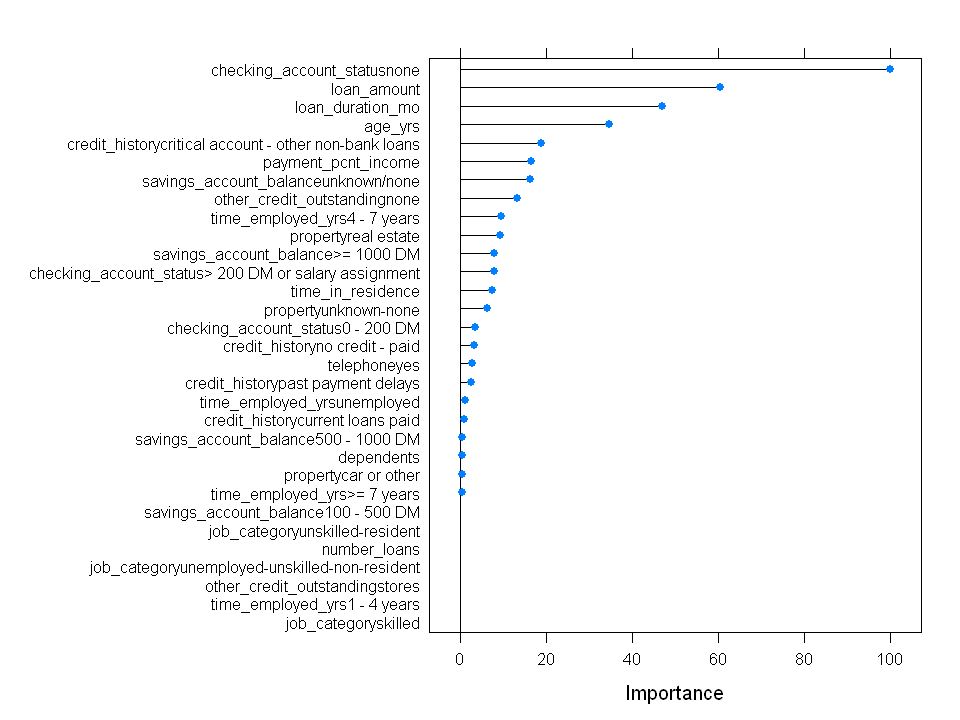

In [31]:
options(repr.plot.width=8, repr.plot.height=6)
var_imp = varImp(bb_fit_inside_tw)
print(var_imp)
plot(var_imp)

In is clear that some of the features are not important to model performance. Execute the code in the cell below to prune the feature set using the dplyr `select` function:

In [32]:
credit_reduced = select(credit, -dependents, -time_employed_yrs, -job_category, -other_credit_outstanding)

Execute the code in the cell below to perform the cross validation grid search using the reduced feature set: 

In [33]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           sampling = 'up',
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)

set.seed(4321)
bb_fit_inside_tw <- train(bad_credit ~ ., 
                          data = credit_reduced,  
                          method = "gbm", # Gradient boosted tree model
                          trControl = fitControl, 
                          verbose = FALSE,
                          metric="ROC")
print(bb_fit_inside_tw)

Stochastic Gradient Boosting 

1000 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 800, 800, 800, 800 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  interaction.depth  n.trees  ROC        Sens       Spec     
  1                   50      0.7458810  0.7466667  0.6300000
  1                  100      0.7646667  0.7233333  0.6728571
  1                  150      0.7575476  0.7100000  0.7057143
  2                   50      0.7560952  0.7000000  0.6757143
  2                  100      0.7603810  0.6900000  0.7000000
  2                  150      0.7610000  0.6733333  0.7257143
  3                   50      0.7743571  0.7166667  0.7128571
  3                  100      0.7663095  0.6966667  0.7314286
  3                  150      0.7653095  0.6566667  0.7528571

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' 

The results of the cross validation grid search with the reduced feature set are nearly the same as the first result. Evidentially, pruning these features was the correct step. This process can be continued, but will not be in this lab in the interest of reducing length. 

To better understand the parameter sweep, execute the code in the cell below to create a chart.

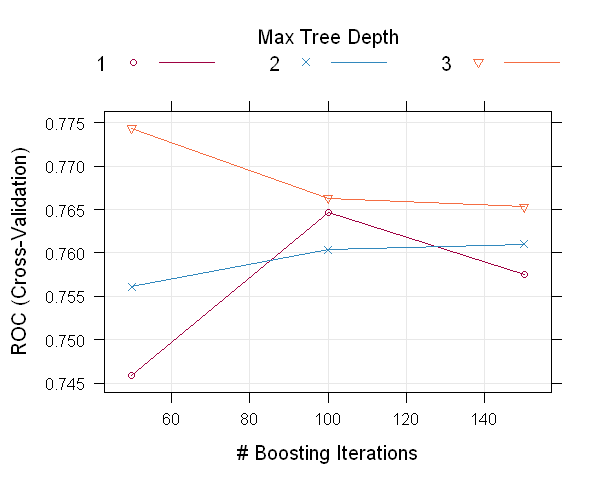

In [34]:
options(repr.plot.width=5, repr.plot.height=4)
trellis.par.set(caretTheme())
plot(bb_fit_inside_tw)  

Examine these results. The ROC is in a narrow range, but there are clear differences for the various . 
hyperpareter choices.

Finally, to verify that the model will generalize well it is time to perform the outside CV loop. The code in the cell below defines a parameter grid with just the optimal hyperparameter values. The CV then repeatedly fits the model with this single hyperparameter. Execute this code and examine the result.

Then, answer **Question 4** on the course page.

In [35]:
## Set the hyperparameter grid to the optimal values from the inside loop
paramGrid <- expand.grid(n.trees = c(100), interaction.depth = c(3), shrinkage = c(0.1), n.minobsinnode = c(10))

set.seed(5678)
bb_fit_outside_tw <- train(bad_credit ~ ., 
                          data = credit_reduced,  
                          method = "gbm", # Gradient boosted tree model
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          verbose = FALSE,
                          metric="ROC")

print_metrics = function(mod){
    means = c(apply(mod$resample[,1:3], 2, mean), n.trees = mod$resample[1,4], interaction.depth = mod$resample[1,5], 
              shrinkage = mod$resample[1,6], n.minobsinnode = mod$resample[1,7], Resample = 'Mean')
    stds = c(apply(mod$resample[,1:3], 2, sd), n.trees = mod$resample[1,4], interaction.depth = mod$resample[1,5], 
              shrinkage = mod$resample[1,6], n.minobsinnode = mod$resample[1,7], Resample = 'STD')
    out = rbind(mod$resample, means, stds)
    out[,1:3] = lapply(out[,1:3], function(x) round(as.numeric(x), 3))
    out
}
print_metrics(bb_fit_outside_tw)

ROC,Sens,Spec,n.trees,interaction.depth,shrinkage,n.minobsinnode,Resample
0.762,0.667,0.771,100,3,0.1,10,Fold1
0.764,0.667,0.757,100,3,0.1,10,Fold2
0.751,0.700,0.721,100,3,0.1,10,Fold3
0.793,0.617,0.814,100,3,0.1,10,Fold4
0.727,0.633,0.657,100,3,0.1,10,Fold5
0.760,0.657,0.744,100,3,0.1,10,Mean
0.024,0.032,0.059,100,3,0.1,10,STD


Examine these results. Notice that the standard deviation of the mean of the AUC are nearly an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

***
**Note:** The predict method can be used with this optimal model to classify unknown cases.
***

## Summary

In this lab you have accomplished the following:
1. Used an AdaBoosted tree model to classify the cases of the iris data. This model produced quite good results. 
2. Used 5 fold to find estimated optimal hyperparameters for an AdaBoosted tree model to classify credit risk cases. The model did not generalize well.
3. Applied up-sampling of the minority cases to create a balanced training dataset and retrained and evaluated the model. 
4. Applied feature importance was used for feature selection. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features. 
5. Used the outer loop of the nested cross validation to demonstrate that the model is likely to generalize.